In [2]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
mnist = fetch_mldata("MNIST original")
pca = PCA(n_components=100)
MX = pca.fit_transform(mnist.data / 255.0)
#MX = mnist.data / 255.0
My = mnist.target
print('Explained total variation: ,', format(sum(pca.explained_variance_ratio_)))

In [3]:
print(MX.shape)

(70000, 784)


In [4]:
rndperm = np.random.permutation(MX.shape[0])

In [5]:
def partitionData(X,y, num_points=10000, num_pivots=500):
    pivots_X = X[:num_pivots]
    pivots_y = y[:num_pivots]
    sample_X = X[num_pivots:num_points+num_pivots]
    sample_y = y[num_pivots:num_points+num_pivots]
    return sample_X, sample_y, pivots_X, pivots_y

In [6]:
def distanceMatrix(X,Y):
    A, _ = np.shape(X)
    B, _ = np.shape(Y)
    X2 = np.sum(X**2, axis=1).reshape(-1,1)
    Y2 = np.sum(Y**2, axis=1).reshape(-1,1)
    XY = X.dot(Y.T)
    dm = X2 - 2*XY + Y2.T
    return dm

def kNN(dm, k=5):
    dm_arr = np.asarray(dm)
    sorted_indices = np.argsort(dm_arr, axis=1)
    sorted_dm = dm_arr[sorted_indices]
    return sorted_dm[:,:k], indices[:,:k]

In [22]:
from sklearn.neighbors import KDTree
def kNN_KDTree(X,pivots_X,k=5):
    N,_ = X.shape
    sorted_dm = np.zeros((N,k))
    sorted_indices = np.zeros((N,k))
    kdtree = KDTree(pivots_X, leaf_size=5)
    for n in range(N):
        sorted_dm[n], sorted_indices[n] = kdtree.query([X[n]], k=k)
    return sorted_dm, sorted_indices.astype(int)

In [38]:
def computeSpringStrengths(pivots_X, sorted_dm, sorted_indices):
    N,k = sorted_dm.shape
    spring_strengths = {}
    for n in range(N):
        for i in range(k):
            for j in range(i+1,k):
                di = sorted_dm[n,i]
                dj = sorted_dm[n,j]
                pi = int(sorted_indices[n,i])
                pj = int(sorted_indices[n,j])
                if pi > pj:
                    pi,pj = pj,pi
                    di,dj = dj,di
                edge = (pi,pj)
                if edge in spring_strengths:
                    spring_strengths[edge]+=(1/(di+dj+1e-12))
                else:
                    D = np.sum((pivots_X[pi]-pivots_X[pj])**2) + 1e-12
                    spring_strengths[edge]=((1/D) + (1/(di+dj+1e-12)))
    return spring_strengths

In [86]:
from scipy import sparse
def getLiLMatrix(num_pivots, graph_dict):
    I, J, V = [], [], []
    for src_dst, weight in graph_dict.items():
        I.append(src_dst[0])
        J.append(src_dst[1])
        V.append(weight)
    lil_matrix = sparse.lil_matrix((num_pivots, num_pivots))
    lil_matrix[I,J] = V
    lil_matrix[J,I] = V
    return lil_matrix

def getKnnFromGraph(num_pivots, lil_matrix, k=10):
    spring_graph = {}
    for p in range(num_pivots):
        neighbors = np.asarray(lil_matrix.rows[p])
        neighbor_dist = np.asarray(lil_matrix.data[p])
        num_neighbors = len(neighbors)
        
        nn_indices = None
        if num_neighbors > k:
            nn_indices = np.argpartition(neighbor_dist, kth=num_neighbors-k)[-k:].astype(int)
        elif num_neighbors > 0:
            nn_indices = range(num_neighbors)
            
        if nn_indices is None:
            continue
        else:
            nn_dist = neighbor_dist[[nn_indices]]
            nn_pivots = neighbors[[nn_indices]]
            for j in range(len(nn_indices)):
                pi = p
                pj = nn_pivots[j]
                dij = nn_dist[j]
                if pi > pj:
                    pi,pj = pj,pi
                edge = (pi,pj)
                if not(edge in spring_graph):
                    spring_graph[edge]=dij
    return spring_graph

In [93]:
import networkx as nx
colors = ["blue", "red", "green", "yellow", "brown", "pink", "orange", "gray", "cyan", "greenyellow"]

def genPivotsGraph(spring_graph_dict, pivots_y):
    P, = pivots_y.shape
    
    G=nx.Graph()
    for i in range(P):
        G.add_node(i, {'color':colors[int(pivots_y[i])], 'cluster':int(pivots_y[i])})
    
    weighted_edges = []
    for src_dst, strength in spring_graph_dict.items():
        weighted_edges.append((src_dst[0],src_dst[1],strength))
        
    G.add_weighted_edges_from(weighted_edges)
    return G

In [101]:
import matplotlib.pyplot as plt

def vizSpringGraph(G, y, dim=2, iterations=100):
    P, = y.shape
    pos = nx.spring_layout(G, dim=dim, iterations=iterations)
    %matplotlib notebook
    plt.ion()
    for n in range(P):
        nx.draw_networkx_nodes(G,pos, with_labels=False, nodelist=[n], node_size=5,
                               node_color=colors[int(y[n])])
    plt.axis('off')
    plt.show()

In [103]:
num_points = 20000
num_pivots = 5000
sample_X, sample_y, pivots_X, pivots_y = partitionData(MX[rndperm], My[rndperm],
                                              num_points=num_points,
                                              num_pivots=num_pivots)
print(sample_X.shape, sample_y.shape, pivots_X.shape, pivots_y.shape)

(20000, 784) (20000,) (5000, 784) (5000,)


In [104]:
sorted_dm, sorted_indices = kNN_KDTree(sample_X, pivots_X, k=10)
print(sorted_dm.shape)
print(sorted_indices.shape)

(20000, 10)
(20000, 10)


In [105]:
print(sorted_dm[0])
print(sorted_indices[0])
print(pivots_y[sorted_indices[0]])
print(sample_y[0])

[ 6.1656625   6.26013918  6.9020488   7.17576446  7.70683624  7.7616631
  7.82971597  7.87194025  7.89659235  8.09193142]
[1435  130 2371 4529 2470 4610 1478  309 1834 4722]
[ 5.  5.  5.  5.  5.  5.  5.  5.  8.  5.]
5.0


In [106]:
spring_strengths = computeSpringStrengths(pivots_X, sorted_dm, sorted_indices)

In [107]:
print(len(spring_strengths))
lil_matrix = getLiLMatrix(num_pivots, spring_strengths)
print(lil_matrix.count_nonzero())

265200
530400


In [108]:
spring_graph = getKnnFromGraph(num_pivots, lil_matrix, k=10)

In [109]:
print(len(spring_graph))

37600


In [110]:
PG = genPivotsGraph(spring_graph, pivots_y)

In [111]:
print(PG.number_of_nodes())
print(PG.number_of_edges())

5000
37600


<IPython.core.display.Javascript object>


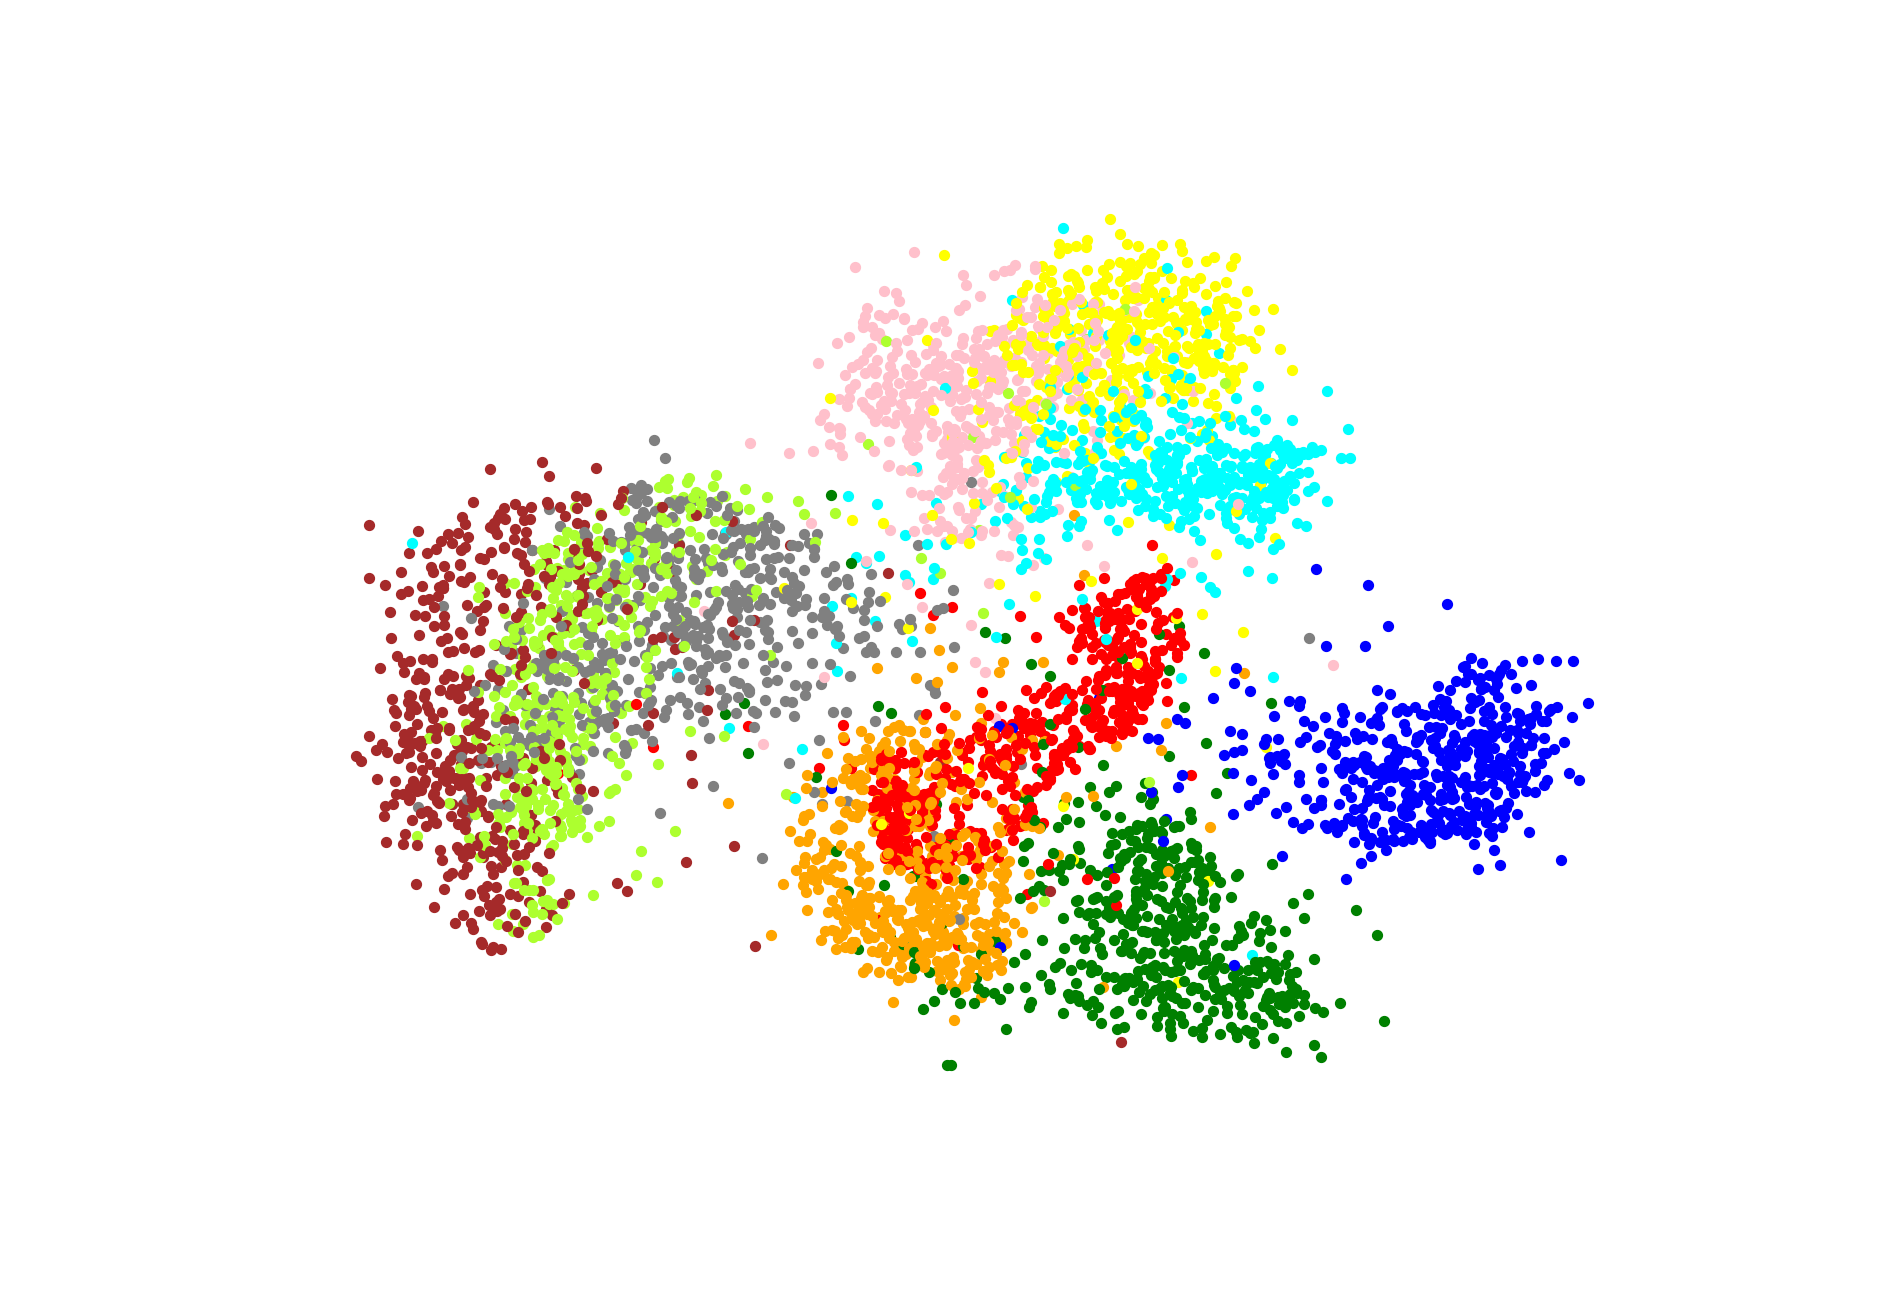

In [112]:
vizSpringGraph(PG, pivots_y, dim=2, iterations=100)